In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

random.seed(42)
np.random.seed(42)

2024-04-07 17:13:02.946582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:13:02.946623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:13:02.947667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 17:13:02.955019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [ ]:
get_available_gpus()

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


2024-04-07 17:13:14.845687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14769 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [4]:

dataset_path = 'train/'

for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        try:
            img = Image.open(filepath)  
            img.verify()  
        except Exception as e:
            print(f"Removing corrupted/unsupported image file: {filepath}, Reason: {e}")
            os.remove(filepath) 


In [5]:
root = 'train'
train_dir = 'train/traning'
validation_dir = 'train/validation'
classes = [dir_name for dir_name in os.listdir(root) if os.path.isdir(os.path.join(root, dir_name))]

In [6]:

train_dirs = {cls: os.path.join(train_dir, cls) for cls in classes}
validation_dirs = {cls: os.path.join(validation_dir, cls) for cls in classes}


In [7]:
for cls in classes:
    source_path = os.path.join(root, cls)
    print(f"There are {len(os.listdir(source_path))} images of {cls}.")

There are 705 images of ice_cream.
There are 2395 images of donuts.
There are 707 images of chicken_curry.
There are 681 images of steak.
There are 679 images of cheesecake.
There are 709 images of falafel.
There are 1057 images of hot_dog.
There are 1501 images of baked_potato.
There are 708 images of cheese_sandwich.
There are 1509 images of spaghetti.
There are 715 images of omelette.
There are 690 images of sushi.
There are 699 images of eggs.
There are 2288 images of chicken.
There are 702 images of chocolate_cake.
There are 2376 images of hamburger.
There are 887 images of pizza.
There are 708 images of fish.
There are 693 images of lasagna.
There are 2286 images of french_fries.
There are 680 images of baklava.
There are 709 images of caesar_salad.


In [8]:

root_dir = 'Dataset'
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path, clss):
   
    train_dir = os.path.join(root_path, 'training')
    validation_dir = os.path.join(root_path, 'validation')
    
    for cls in clss:
        train_cls_dir = os.path.join(train_dir, cls)
        validation_cls_dir = os.path.join(validation_dir, cls)

        os.makedirs(train_cls_dir)
        os.makedirs(validation_cls_dir)

    pass

In [9]:
try:
    create_train_val_dirs(root_path=root_dir, clss=classes)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [10]:
for rootdir, dirs, files in os.walk('Dataset'):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

Dataset/training
Dataset/validation
Dataset/training/ice_cream
Dataset/training/donuts
Dataset/training/chicken_curry
Dataset/training/steak
Dataset/training/cheesecake
Dataset/training/falafel
Dataset/training/hot_dog
Dataset/training/baked_potato
Dataset/training/cheese_sandwich
Dataset/training/spaghetti
Dataset/training/omelette
Dataset/training/sushi
Dataset/training/eggs
Dataset/training/chicken
Dataset/training/chocolate_cake
Dataset/training/hamburger
Dataset/training/pizza
Dataset/training/fish
Dataset/training/lasagna
Dataset/training/french_fries
Dataset/training/baklava
Dataset/training/caesar_salad
Dataset/validation/ice_cream
Dataset/validation/donuts
Dataset/validation/chicken_curry
Dataset/validation/steak
Dataset/validation/cheesecake
Dataset/validation/falafel
Dataset/validation/hot_dog
Dataset/validation/baked_potato
Dataset/validation/cheese_sandwich
Dataset/validation/spaghetti
Dataset/validation/omelette
Dataset/validation/sushi
Dataset/validation/eggs
Dataset/val

In [11]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    for img in os.listdir(SOURCE_DIR):
        dir = os.path.join(SOURCE_DIR, img)
        if os.path.getsize(dir) == 0:
            os.remove(dir)
            print (img, "is zero length, so ignoring.")

    proportion = int(len(os.listdir(SOURCE_DIR)) * SPLIT_SIZE)

    sample_list = random.sample(os.listdir(SOURCE_DIR), proportion)

    orginal_set = set(os.listdir(SOURCE_DIR))

    sample_set = set(sample_list)
    temp1 = [x for x in orginal_set if x not in sample_set]

    for img in sample_list:
        dir = os.path.join(SOURCE_DIR, img)
        dir1 = os.path.join(TRAINING_DIR, img)
        shutil.copyfile(dir, dir1)

    for img in temp1:
        dir = os.path.join(SOURCE_DIR, img)
        dir1 = os.path.join(VALIDATION_DIR, img)
        shutil.copyfile(dir, dir1)
    pass

In [12]:

MAIN_SOURCE_DIR = "train/"

TRAINING_DIR = "Dataset/training/"
VALIDATION_DIR = "Dataset/validation/"

for cls in classes:
    if len(os.listdir(TRAINING_DIR+cls+'/')) > 0:
        for file in os.scandir(TRAINING_DIR+cls+'/'):
            os.remove(file.path)
            
    if len(os.listdir(VALIDATION_DIR+cls+'/')) > 0:
        for file in os.scandir(VALIDATION_DIR+cls+'/'):
            os.remove(file.path) 

split_size = 0.9

for cls in classes:
    split_data(MAIN_SOURCE_DIR+cls+'/', TRAINING_DIR+cls+'/', VALIDATION_DIR+cls+'/', split_size)

In [13]:
for cls in classes:
    print(f"\n\nOriginal {cls}'s directory has {len(os.listdir(MAIN_SOURCE_DIR+cls+'/'))} images")
    print(f"\n\nThere are {len(os.listdir(TRAINING_DIR+cls+'/'))} images of {cls} for training")
    print(f"There are {len(os.listdir(VALIDATION_DIR+cls+'/'))} images of {cls} for validation")



Original ice_cream's directory has 705 images


There are 634 images of ice_cream for training
There are 71 images of ice_cream for validation


Original donuts's directory has 2395 images


There are 2155 images of donuts for training
There are 240 images of donuts for validation


Original chicken_curry's directory has 707 images


There are 636 images of chicken_curry for training
There are 71 images of chicken_curry for validation


Original steak's directory has 681 images


There are 612 images of steak for training
There are 69 images of steak for validation


Original cheesecake's directory has 679 images


There are 611 images of cheesecake for training
There are 68 images of cheesecake for validation


Original falafel's directory has 709 images


There are 638 images of falafel for training
There are 71 images of falafel for validation


Original hot_dog's directory has 1057 images


There are 951 images of hot_dog for training
There are 106 images of hot_dog for validatio

## Image Data Generators for Machine Learning Training and Validation

### Overview
The function `train_val_generators` prepares image data generators for training and validation datasets, using data augmentation techniques for the training set to improve model generalization and avoid overfitting.

### Training Data Generator

- **Rescaling**: Pixel values are rescaled from 0-255 to 0-1 by multiplying by 1.0/255, which helps in normalizing the data.
- **Augmentation Techniques**:
  - **Rotation**: Images are randomly rotated by up to 0.2 degrees.
  - **Width and Height Shift**: Images are randomly shifted horizontally and vertically by 20% of their dimensions.
  - **Shear**: Images are sheared by 0.2 radians to create slant transformations.
  - **Zoom**: Random zooming into images by up to 20%.
  - **Horizontal Flip**: Images are randomly flipped horizontally.
  - **Fill Mode**: Newly created pixels after a transformation are filled with the 'nearest' pixel values.

### Validation Data Generator

- **Rescaling**: Similar to the training generator, pixel values are rescaled.
- **No Additional Augmentation**: To ensure the validation data reflects real-world scenarios without artificial enhancements.


### Function Output

- Returns two generators: `train_generator` for training images with augmentation, `validation_generator` for validation images without augmentation.
- These generators are then used in training the model, typically by passing them to the `fit` method of a Keras model.


In [14]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(rescale= 1.0 / 255.,
                                       rotation_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=128,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        classes=classes,
                                                        seed=42,
                                                        target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale= 1.0/255.0)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=16,
                                                                  class_mode='categorical',
                                                                  color_mode='rgb',
                                                                  classes=classes,
                                                                  seed=42,
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

In [15]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 21668 images belonging to 22 classes.
Found 2416 images belonging to 22 classes.


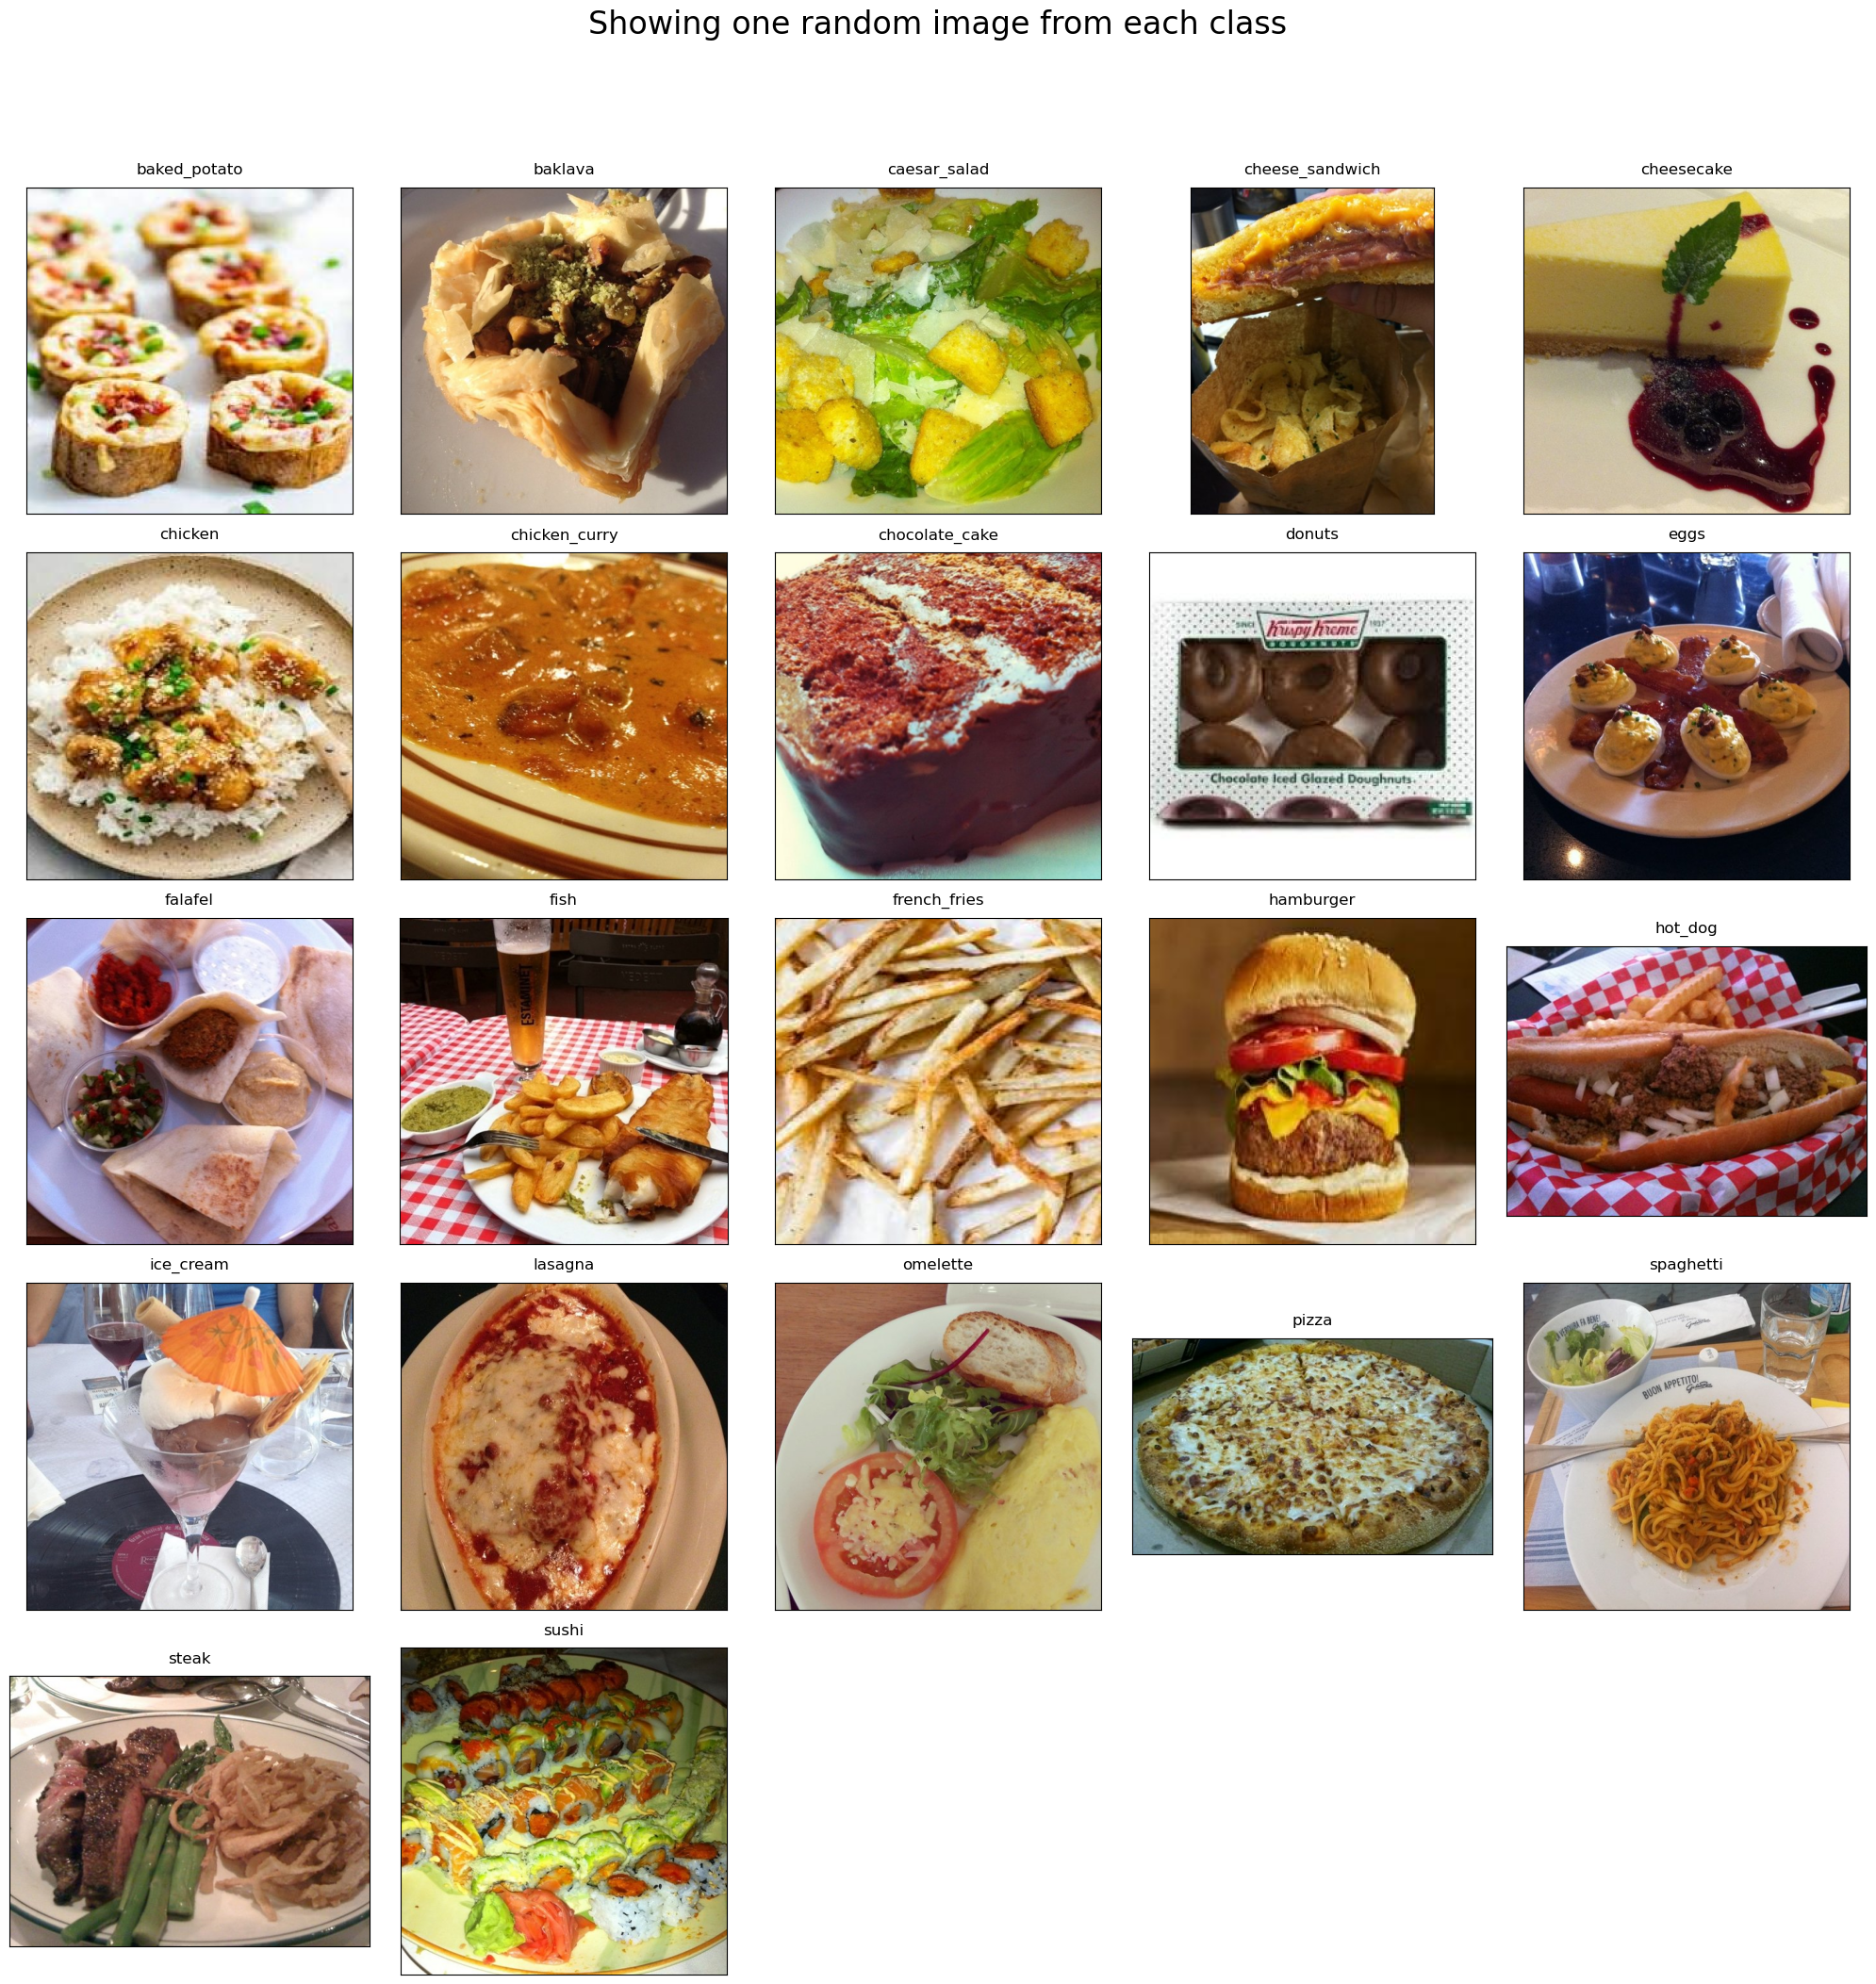

In [16]:
data_dir = "Dataset/training/"
foods_sorted = sorted([item for item in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, item))])

rows, cols = (5, 5)
fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)

food_id = 0

for i in range(rows):
    for j in range(cols):
        if food_id >= len(foods_sorted):  
            ax[i, j].axis('off')  
            continue  
        food_selected = foods_sorted[food_id]
        food_id += 1  
        
        food_selected_images = os.listdir(os.path.join(data_dir, food_selected))
        food_selected_random = np.random.choice(food_selected_images)
        img_path = os.path.join(data_dir, food_selected, food_selected_random)
        img = plt.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title(food_selected, pad=10)
        ax[i, j].set_xticks([])  
        ax[i, j].set_yticks([])  
plt.tight_layout()
plt.show()


In [ ]:
def create_model():
    model = tf.keras.models.Sequential([ 
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = (150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.2),

            #tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            #tf.keras.layers.MaxPooling2D(2, 2),
            #tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            #tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(22, activation='softmax')
    ])


    model.compile(optimizer=Adam(learning_rate = 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])  

    return model

In [ ]:

model = create_model()

history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O model_weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = 'model_weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Function: create_pre_trained_model

### Purpose
This function initializes a pre-trained InceptionV3 model configured for transfer learning. It loads the model with custom weights from a local file and configures the layers to be non-trainable.


### Implementation Details
- **Model Configuration**:
  - **InceptionV3 Model**: A convolutional neural network architecture from the Inception family. Chosen for its efficiency and accuracy in image classification tasks.
  - **Input Shape**: The input size is set to 150x150 pixels with 3 color channels (RGB), suitable for various image recognition tasks.
  - **Include Top**: Set to `False` to exclude the top layer (fully connected layer), which allows for custom layer additions appropriate for new tasks.
  - **Weights**: Initially set to `None` because the model will use weights from a specified local file instead of default ImageNet weights.

- **Weights Loading**:
  - Loads the weights from `local_weights_file` into the pre-trained model, enabling the model to retain learned features relevant to the new task.

- **Layer Configuration**:
  - All layers in the pre-trained model are set to non-trainable (`layer.trainable = False`). This is to freeze the existing learned features during the training of any new layers, enhancing the transfer learning effect by focusing training on task-specific adaptations.

### Output
- Returns the configured InceptionV3 model as `pre_trained_model`. This model serves as a solid foundation for building a new classification or feature extraction model, tailored to specific needs by adding and training new top layers.

### Usage
The returned model can be directly integrated into a machine learning pipeline where new trainable layers can be added atop the frozen base to tailor the model to new data or tasks.



In [18]:
def create_pre_trained_model(local_weights_file):
    
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False


    return pre_trained_model
  

In [19]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [20]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


### Purpose

This setup enables the model to stop training as soon as the accuracy reaches or exceeds 99.9%, thus preventing overfitting and saving computational resources.


In [21]:
class myCallback(tf.keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
        print("\nReached 99.9% accuracy so cancelling training!")
        self.model.stop_training = True

## Using InceptionV3 up to the 'mixed7' Layer

### Overview
In the InceptionV3 model, when targeting the 'mixed7' layer, we utilize all preceding layers from the input through 'mixed7'. This approach leverages the deep and complex features extracted by these layers, beneficial for various image processing tasks.

### Key Points

- **Layer Utilization**:
  - By extracting output from 'mixed7', we are effectively using all the layers from the beginning of the model to this intermediate layer.
  - This includes various convolutional, normalization, and pooling layers that process and transform the input data into increasingly abstract representations.

- **Purpose of Partial Utilization**:
  - **Transfer Learning**: This strategy is commonly used in transfer learning where general features extracted by initial layers are adapted for more specific tasks by adding custom layers beyond 'mixed7'.
  - **Customization**: Allows for customization after 'mixed7' to better address specific needs, such as new classification layers or other structures tailored to the task at hand.

- **Advantages**:
  - **Efficiency**: Using only a part of the network can be computationally less intensive and quicker, especially beneficial when the full capability of InceptionV3 is not required.
  - **Flexibility**: Provides the flexibility to design the neural network architecture beyond 'mixed7' to optimize for particular tasks, enhancing the model's effectiveness on specific datasets or problems.


In [22]:
def output_of_last_layer(pre_trained_model):

    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output


In [23]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [24]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [25]:
def create_final_model(pre_trained_model, last_output):
    
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)  
    x = layers.Dense(22, activation='softmax')(x)        

    model = Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])


    return model


In [26]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,534,006 total parameters in this model.
There are 38,558,742 trainable parameters in this model.


In [27]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100


2024-04-07 17:18:28.509853: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-07 17:18:33.647091: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f71e8022d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 17:18:33.647188: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-04-07 17:18:33.665410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712499513.856325   46495 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 [==============================] - 195s 1s/step - loss: 1.6237 - accuracy: 0.5326 - val_loss: 1.0757 - val_accuracy: 0.6759
Epoch 2/100
170/170 [==============================] - 167s 982ms/step - loss: 1.1523 - accuracy: 0.6585 - val_loss: 0.9618 - val_accuracy: 0.7132
Epoch 3/100
170/170 [==============================] - 171s 1s/step - loss: 1.0427 - accuracy: 0.6904 - val_loss: 0.8864 - val_accuracy: 0.7450
Epoch 4/100
170/170 [==============================] - 182s 1s/step - loss: 0.9497 - accuracy: 0.7171 - val_loss: 0.9128 - val_accuracy: 0.7392
Epoch 5/100
170/170 [==============================] - 164s 963ms/step - loss: 0.8937 - accuracy: 0.7331 - val_loss: 0.8796 - val_accuracy: 0.7380
Epoch 6/100
170/170 [==============================] - 186s 1s/step - loss: 0.8520 - accuracy: 0.7436 - val_loss: 0.8362 - val_accuracy: 0.7645
Epoch 7/100
170/170 [==============================] - 167s 980ms/step - loss: 0.8258 - accuracy: 0.7532 - val_loss: 0.8283 - val_accuracy: 0.

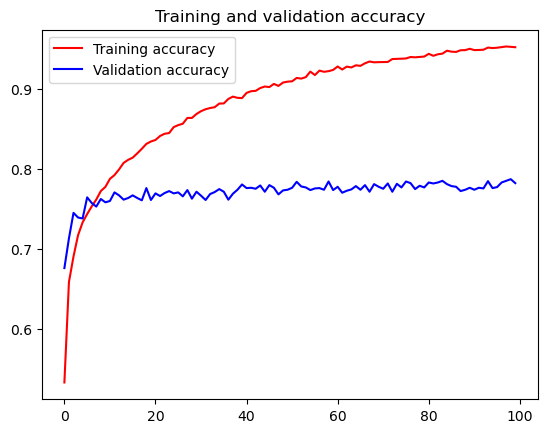

<Figure size 640x480 with 0 Axes>

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

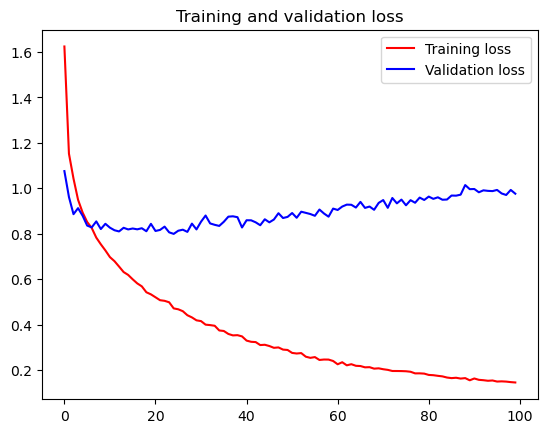

<Figure size 640x480 with 0 Axes>

In [29]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()